In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import seaborn as sns

from utils import *
from IPython.display import JSON

%config InlineBackend.figure_format = 'retina'

font_dirs = ['/Library/Fonts/']
font_files = mpl.font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    mpl.font_manager.fontManager.addfont(font_file)
mpl.rcParams['font.family'] = 'Barlow'
sns.set(font='Barlow')

palette = color = ['#223E5C','#5EACA3','#F1D670','#DC6046']
palette_cb = ['#364B9A','#6EA6CD','#C2E4EF','#EAECCC','#FEDA8B','#F67E4B','#A50026']
palette_cb_long = ['#364B9A','#4A7BB7','#6EA6CD','#98CAE1','#C2E4EF','#EAECCC','#FEDA8B','#FDB366','#F67E4B','#DD3D2D','#A50026']
vale_palette = ['#D5E5F4','#B0CDE8','#93ADC7','#F6DC91','#EDB283','#E09791','#CAB4D5','#A47CB6','#7F4598','#ADD5BB','#75B588','#489657']

istat_age_map_dict = {
  'Y15-19':'15-19 y', 'Y20-24':'20-24 y', 'Y25-29':'25-29 y', 'Y30-34':'30-34 y',
  'Y35-39':'35-39 y', 'Y40-44':'40-44 y', 'Y45-49':'45-49 y', 'Y50-54':'50-54 y',
  'Y55-59':'55-59 y', 'Y60-64':'60-64 y', 'Y_GE65':'65+ y'}
edu_map = {
  'licenza di scuola elementare, nessun titolo di studio':'Lower Secondary or below',
  'licenza di scuola media':'Lower Secondary or below',
  'diploma 2-3 anni (qualifica professionale)':'Upper Secondary',
  'diploma 4-5 anni (maturità)':'Upper Secondary', 
  'laurea e post-laurea':'Bachelor or above'
}
def AGE_map_age_to_group(age: int) -> str:
    if pd.isna(age):
        return None
    bins = [15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, float('inf')]
    labels = ['15-19 y','20-24 y','25-29 y','30-34 y','35-39 y','40-44 y',
              '45-49 y','50-54 y','55-59 y','60-64 y','65+ y']
    return pd.cut([age], bins=bins, labels=labels, right=False)[0]

In [2]:
### Function that load and shape data from both EUROSTAT/ISTAT (Italian statistical office) and MixIT
def load_and_prepare_data(age_col, new_bins, new_bin_labels):
    # Load National Statistical Office data
    age_gender_region = pd.read_csv('data_in/age_gender_region.csv')
    age_gender_education = pd.read_csv('data_in/age_gender_istruzione.csv')
    
    # Reshape joint distribution for age/gender/nuts1
    AGR = age_gender_region[['sex','age','geo','OBS_VALUE']].copy()
    for col in ['sex','age','geo']:
        AGR[col] = AGR[col].apply(lambda x: x.split(':')[1])
    AGR['age'] = AGR['age'].apply(lambda x: int(x.replace(' years','').replace(' year','').replace('Less than 1','0')))
    AGR[age_col] = pd.cut(AGR['age'],bins=new_bins,labels=new_bin_labels, include_lowest=True, right=False)
    AGR['geo'] = AGR['geo'].map({'Nord-Ovest':'North-West','Nord-Est':'North-East','Centro (IT)':'Centre','Sud':'South','Isole':'Islands'})
    AGR['sex'] = AGR['sex'].map({'Females':'F','Males':'M'})
    AGR = AGR[AGR['sex']!='Total']
    AGR = AGR.groupby([age_col,'sex','geo'], observed=False)['OBS_VALUE'].sum().reset_index().rename(columns={'OBS_VALUE':'pop','sex':'part_gender','geo':'region_nuts1'})
    
    # Reshape joint distribution for age/gender/educational_attainment
    AGE = age_gender_education[(age_gender_education['Territorio']=='Italia')&
                               (age_gender_education['Seleziona periodo']=='2020')&
                               (age_gender_education['Sesso']!='totale')&
                               (age_gender_education['Titolo di studio']!='totale')].copy()
    AGE = AGE[~(AGE['ETA1'].isin(['Y_GE15','Y15-24','Y25-34','Y35-64','Y15-64']))]
    AGE['educational_attainment'] = AGE['Titolo di studio'].map(edu_map)
    AGE['part_gender'] = AGE['Sesso'].map({'maschi':'M','femmine':'F'})
    AGE['i_'+age_col] = pd.Categorical(AGE['ETA1'].map(istat_age_map_dict), categories=istat_age_map_dict.values())
    AGE = ((AGE.groupby(['educational_attainment','part_gender','i_'+age_col], observed=False)[['Value']].sum())*1000).reset_index()
    AGE = AGE.rename(columns={'Value':'pop'})

    # Load respondents' and contacts' data
    pe = pd.read_csv(f"data_out/MixIT/participant_extra_MixIT_2022_2023.csv")
    cs = pd.read_csv(f"data_out/contacts_prol_prop_5y_agegroups.csv")
    ri = pd.read_csv(f"data_out/participants_rich_5y_agegroups.csv")
    ri = ri.merge(pe[['part_id','region_nuts1']], on='part_id')
    ########################################################################
    ### Selecting contacts and respondents of interest 
    ########################################################################
    contactToPlot = cs[cs['is_soft']!=True].copy() # The number of contacts an individual had is computed as the non-overlapping sum of the direct contacts and the indirect contacts minus the indoor direct contacts
    contactToPlot = contactToPlot.merge(ri[['part_id']],on='part_id', how='right')
    respondentToPlot = ri.copy()
    
    respondentToPlot['i_'+age_col] = respondentToPlot['part_age'].apply(AGE_map_age_to_group)
    respondentToPlot[age_col] = pd.cut(respondentToPlot['part_age'],bins=new_bins,labels=new_bin_labels, include_lowest=True, right=False)
    contactToPlot[age_col] = pd.cut(contactToPlot['part_age'],bins=new_bins,labels=new_bin_labels, include_lowest=True, right=False)
    respondentToPlot = respondentToPlot.merge(AGE[['educational_attainment','part_gender','i_'+age_col,'pop']],on=['educational_attainment','part_gender','i_'+age_col], how='left')
    
    ### Setting up sub-group specific populations
    AGR['AgeGender_Na'] = AGR.groupby([age_col,'part_gender'], observed=False)['pop'].transform("sum")
    AGR['AgeRegion_Na'] = AGR.groupby([age_col,'region_nuts1'], observed=False)['pop'].transform("sum")
    AGR['GenderRegion_Na'] = AGR.groupby(['part_gender','region_nuts1'], observed=False)['pop'].transform("sum")
    
    AGE['AgeGender_Na'] = AGE[['i_'+age_col,'part_gender']].apply(lambda x: zip_col_vals(x), axis=1)
    AGE['AgeGender_Na'] = AGE['AgeGender_Na'].map(respondentToPlot.drop_duplicates(['i_'+age_col,'part_gender','educational_attainment']).groupby(['i_'+age_col,'part_gender'])['pop'].sum().to_dict()).replace(0,np.nan)
    AGE['AgeEdu_Na'] = AGE[['i_'+age_col,'educational_attainment']].apply(lambda x: zip_col_vals(x), axis=1)
    AGE['AgeEdu_Na'] = AGE['AgeEdu_Na'].map(respondentToPlot.drop_duplicates(['i_'+age_col,'part_gender','educational_attainment']).groupby(['i_'+age_col,'educational_attainment'])['pop'].sum().to_dict()).replace(0,np.nan)
    AGE['GenderEdu_Na'] = AGE[['part_gender','educational_attainment']].apply(lambda x: zip_col_vals(x), axis=1)
    AGE['GenderEdu_Na'] = AGE['GenderEdu_Na'].map(respondentToPlot.drop_duplicates(['i_'+age_col,'part_gender','educational_attainment']).groupby(['part_gender','educational_attainment'])['pop'].sum().to_dict()).replace(0,np.nan)

    return respondentToPlot, contactToPlot, AGR, AGE

### Representativeness on EUROSTAT/ISTAT

In [4]:
### Run representativeness 
age_col = 'part_age_group'
new_bins = [0,10,20,30,40,50,60,70,120]
new_bin_labels = ['0-9 y','10-19 y','20-29 y','30-39 y',
                  '40-49 y','50-59 y','60-69 y','70+ y']
# new_bins = [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,120]
# new_bin_labels = ['0-4 y','5-9 y','10-14 y','15-19 y','20-24 y','25-29 y','30-34 y','35-39 y',
#                   '40-44 y','45-49 y','50-54 y','55-59 y','60-64 y','65-69 y','70+ y']

respondentToPlot, contactToPlot, AGR, AGE = load_and_prepare_data(age_col, new_bins, new_bin_labels)

##########################################
r = (respondentToPlot[[age_col,'part_id']].drop_duplicates([age_col,'part_id']).dropna().groupby([age_col], observed=False)['part_id'].nunique()/contactToPlot[[age_col,'part_id']].drop_duplicates([age_col,'part_id']).dropna()['part_id'].nunique()).reset_index()
r.columns = [age_col, 'survey data']
r = r.set_index(age_col)
p = AGR.groupby(age_col, observed=False)['pop'].sum().to_frame()
p = p/p.sum()
toBar = r.merge(p.dropna(), on=age_col)/r.merge(p.dropna(), on=age_col).sum()

age_group_loc = respondentToPlot.sort_values('part_age')[age_col].unique()


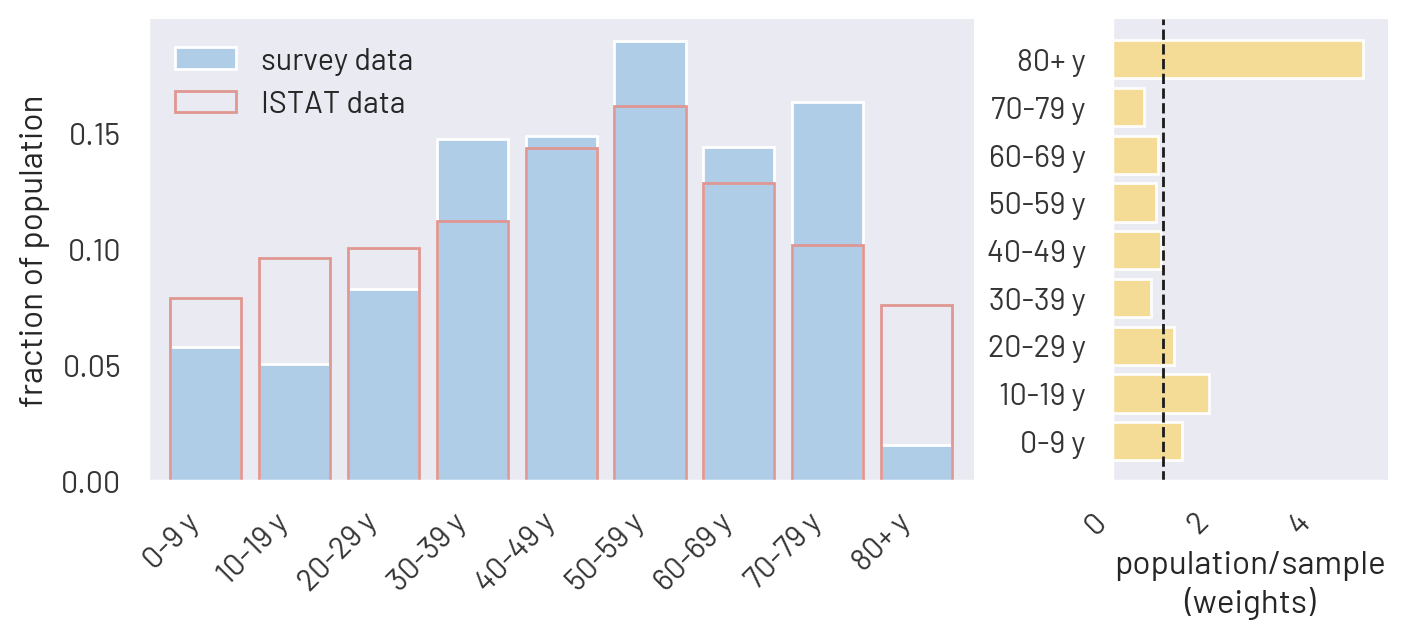

In [9]:
# Figure: 2 columns
fig, (ax1, ax2) = plt.subplots(
    ncols=2, figsize=(8, 3),
    gridspec_kw={"width_ratios": [3, 1], "wspace": 0.25}
)

# --- LEFT PANEL: fractions (same as yours) ---
toBar.loc[age_group_loc][['survey data']].plot(
    kind='bar', ax=ax1, color=[vale_palette[1]], width=0.8
)
ax1.bar(
    range(len(toBar.loc[age_group_loc])),
    height=toBar.loc[age_group_loc]['pop'],
    width=0.8, color='#00000000', edgecolor=vale_palette[5], label='ISTAT data'
)
set_plot_style(ax1)
ax1.set_ylabel('fraction of population')
ax1.set_xlabel('')
ax1.legend(frameon=False)

# --- RIGHT PANEL: relative weights (population ÷ sample) as HORIZONTAL bars ---
eps = 1e-12  # safety if any sample fraction is 0
weights = (
    toBar['pop'].div(toBar['survey data'] + eps)
).loc[age_group_loc]

ypos = np.arange(len(weights))
ax2.barh(ypos, list(weights)[::-1], height=0.8, color=vale_palette[3], alpha=0.95)

# reference line at 1 (perfect representativeness)
ax2.axvline(1, linestyle='--', linewidth=1, color='k')
# ax2.axvline(2, linestyle='--', linewidth=1, color='k')

# tidy axes
ax2.set_yticks(ypos)
ax2.set_yticklabels(list(age_group_loc)[::-1])
ax2.invert_yaxis()  # youngest on top → matches left-to-right order visually
set_plot_style(ax2)
ax2.set_xlabel('population/sample\n(weights)')
ax2.set_ylabel('')

# a sensible x-limit
xmax = float(np.nanmax(weights.values))
ax2.set_xlim(0, xmax * 1.1 if xmax > 1 else 1.5)

# Save
fig.savefig('figures_out/SIfigure2_representativeness.pdf',bbox_inches='tight')

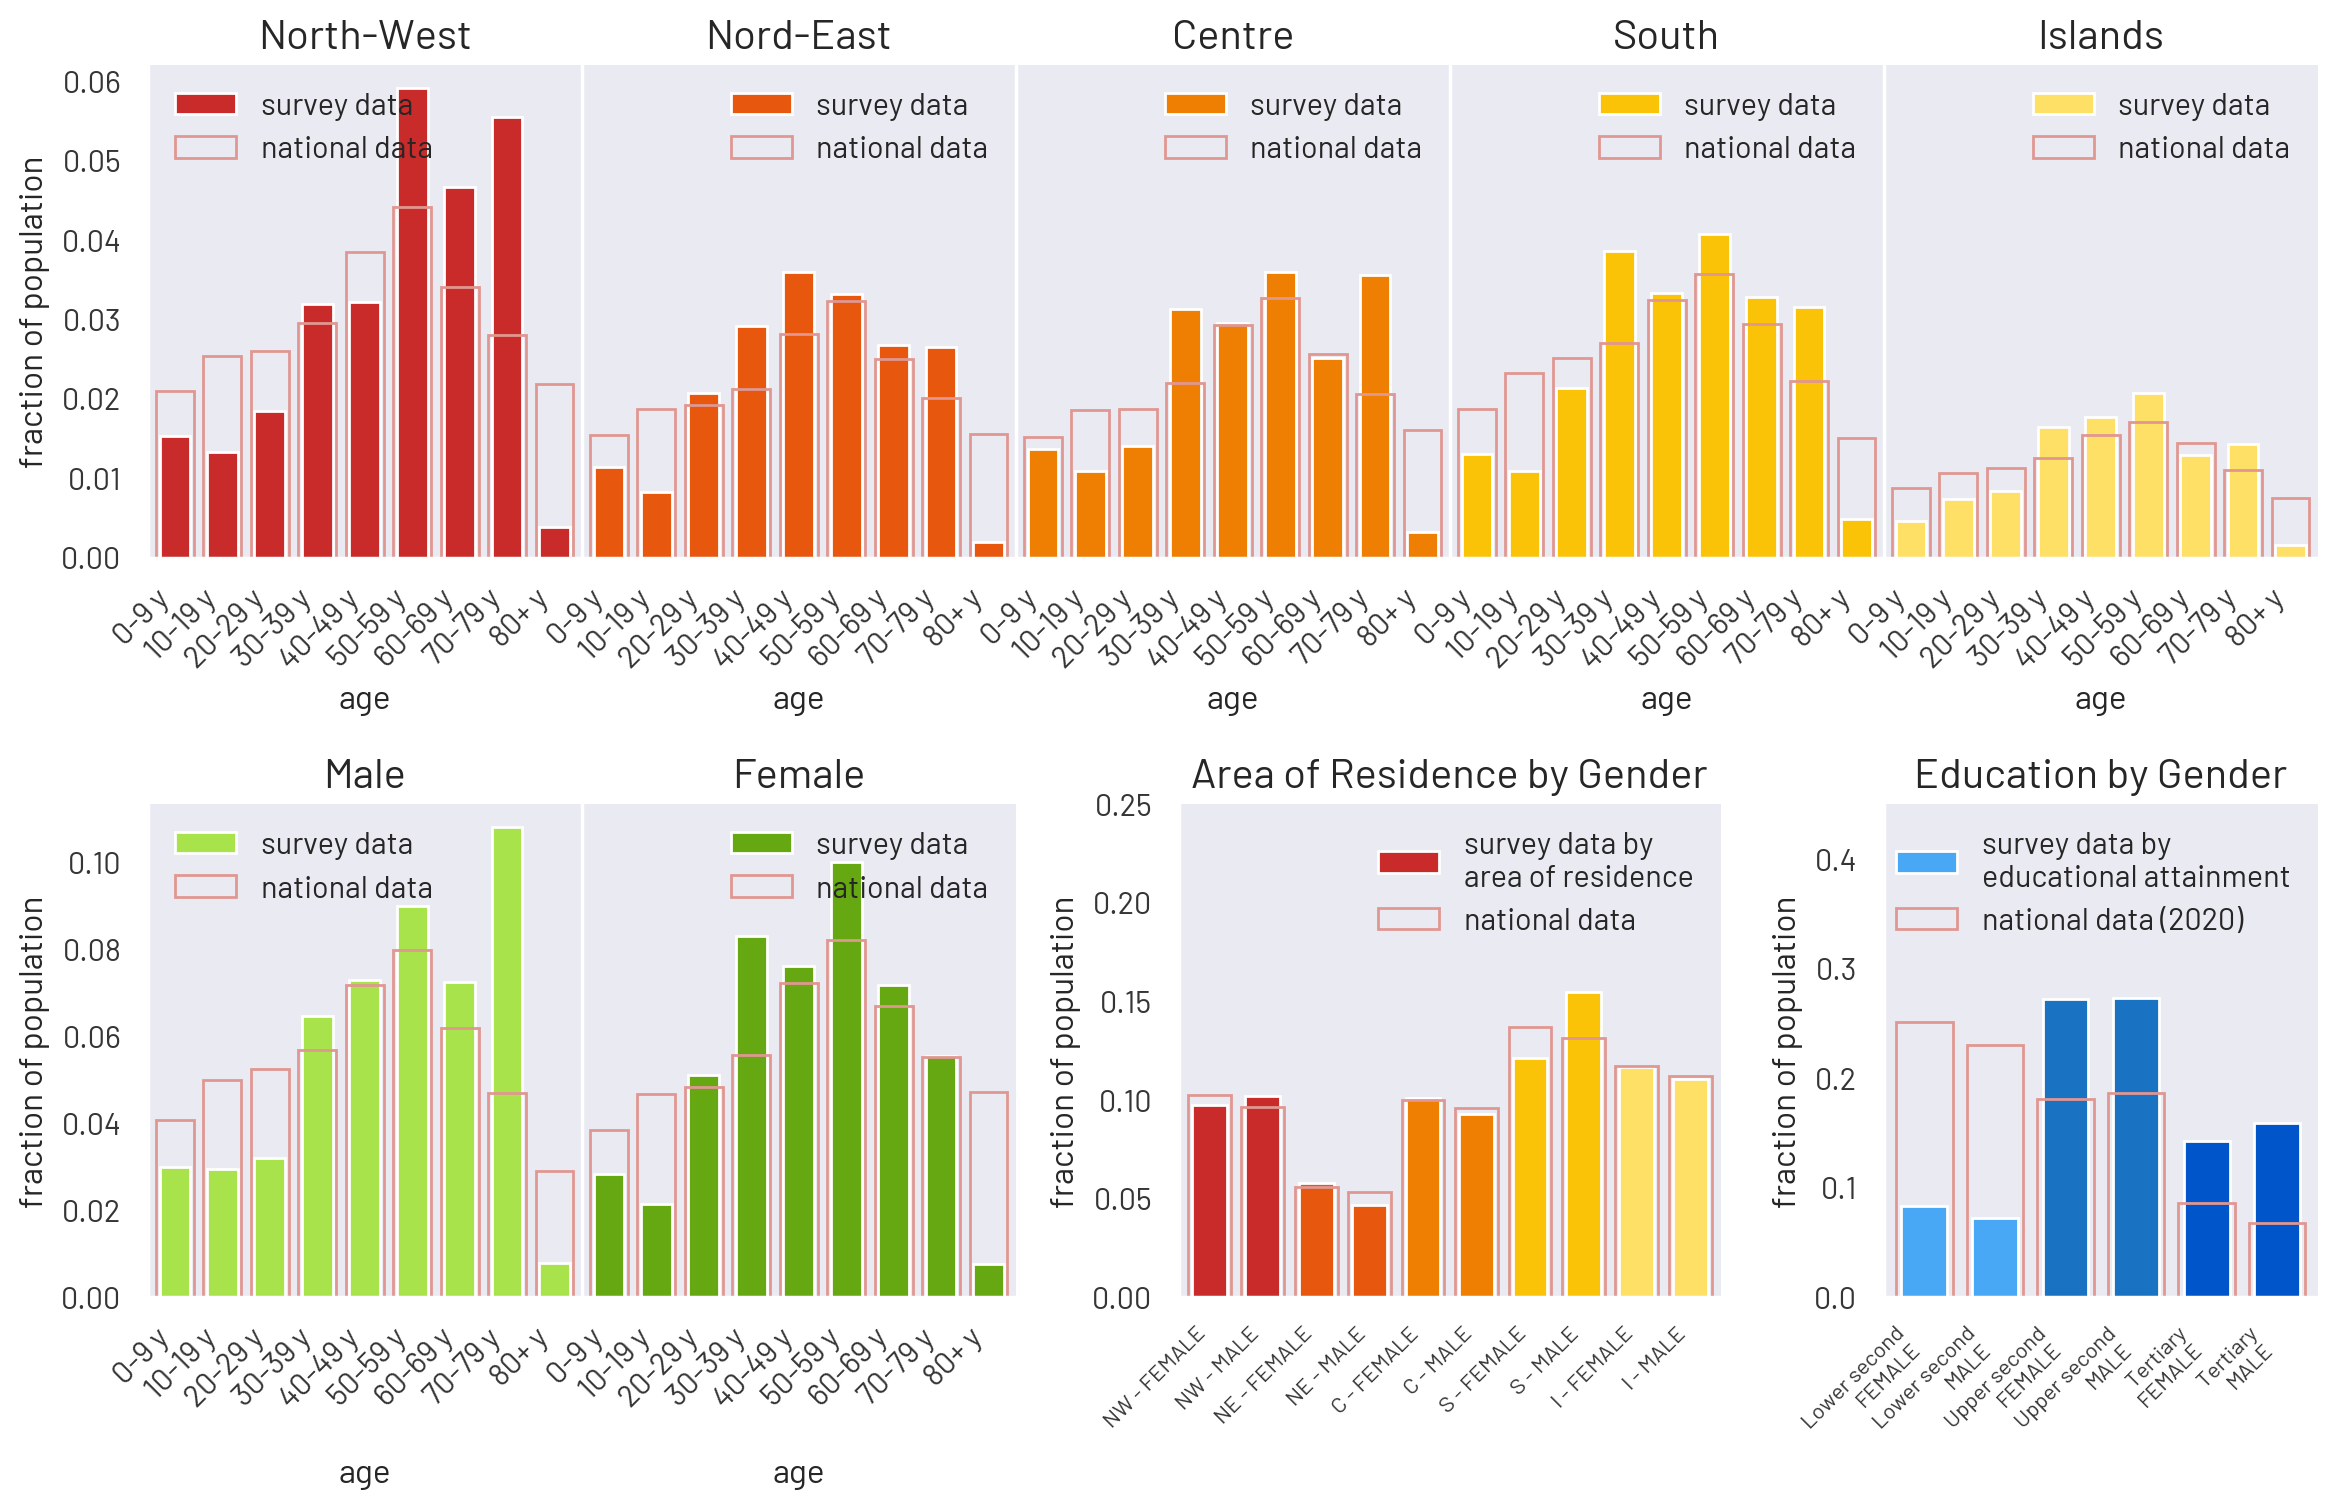

In [10]:
fig, ax = plt.subplot_mosaic([['A1','A2','A3','A3', 'A4','A4','A4', 'A5'],['B1','B2','I1','C1','C1','C1','I2','C2']], 
                             width_ratios=[0.2,0.2, 0.075,0.125, 0.1,0.025,0.075, 0.2],figsize=(14,8))

c1, c2 = 'region_nuts1', age_col

color_palette = ['#C82B2A', '#E7570D', '#EE7F02', '#FAC307', '#FEE067', '#A8E34C', '#66A811', '#1A72C3']
# color_palette = ['#FFD9A8', '#FFC178', '#FD7E14', '#D15819', '#CD2C29', '#3C85C7', '#7CA2A1', '#0ABDA0', '#2ABA9E']
sub_dict = {
    'A1':respondentToPlot[respondentToPlot[c1]=='North-West'].copy(),
    'A2':respondentToPlot[respondentToPlot[c1]=='North-East'].copy(),
    'A3':respondentToPlot[respondentToPlot[c1]=='Centre'].copy(),
    'A4':respondentToPlot[respondentToPlot[c1]=='South'].copy(),
    'A5':respondentToPlot[respondentToPlot[c1]=='Islands'].copy(),
           }
x_labs = sorted(respondentToPlot[c2].unique())
x_title = ['North-West','Nord-East','Centre','South','Islands']
        
for i, (axs, sub_c) in enumerate(sub_dict.items()):
    AGR_sub = AGR[AGR[c1].isin(sub_c[c1].unique())]
    plot_istat_distributions(sub_c, AGR_sub, [c1,c2], ax[axs], color_palette=color_palette[i], box_color=vale_palette[5], base_col='pop', surve_istat_denoms=[respondentToPlot['part_id'].nunique(), AGR['pop'].sum()])
    if i!=0:
        ax[axs].set_xticklabels(x_labs)
        ax[axs].set_yticklabels([])
        set_plot_style(ax[axs],ylabel=' ', title=x_title[i])
        ax[axs].legend(frameon=False)
        ax[axs].sharey(ax['A1'])
    else:
        ax[axs].legend(frameon=False)
        set_plot_style(ax[axs], title=x_title[i])
        ax[axs].set_xticklabels(x_labs)
        ax[axs].legend(frameon=False)
    ax[axs].set_xlabel('age')

    
c1, c2 = 'part_gender', age_col
sub_dict = {
    'B1':respondentToPlot[respondentToPlot[c1]=='M'].copy(),
    'B2':respondentToPlot[respondentToPlot[c1]=='F'].copy(),
           }
x_labs = sorted(respondentToPlot[c2].unique())
x_title = ['Male', 'Female']
# color_palette=['#B67CA7','#B61B8D','#9E7EB2','#B5557B']
for j, (axs, sub_c) in enumerate(sub_dict.items()):
    AGR_sub = AGR[AGR[c1].isin(['M','F'])]
    plot_istat_distributions(sub_c, AGR_sub, [c1,c2], ax[axs], color_palette=color_palette[j+i+1], box_color=vale_palette[5], base_col='pop', surve_istat_denoms=[respondentToPlot['part_id'].nunique(), AGR['pop'].sum()])
    if j!=0:
        ax[axs].set_xticklabels(x_labs)
        ax[axs].set_yticklabels([])
        set_plot_style(ax[axs],ylabel=' ', title=x_title[j])
        ax[axs].legend(frameon=False)
        ax[axs].sharey(ax['B1'])
    else:
        ax[axs].legend(frameon=False)
        set_plot_style(ax[axs], title=x_title[j])
        ax[axs].set_xticklabels(x_labs)
        ax[axs].legend(frameon=False)
    ax[axs].set_xlabel('age')

        


c1, c2 = 'region_nuts1', 'part_gender',
sub_dict = {'C1':respondentToPlot.copy()}

x_labs = list(itertools.product(['NW - ','NE - ','C - ','S - ','I - '], ['FEMALE', 'MALE']))
x_labs = [l[0]+l[1] for l in x_labs]
x_title = ["Area of Residence by Gender"]

plot_istat_distributions(sub_dict['C1'], AGR, [c1,c2], ax['C1'], color_palette=[color for cl1 in [[c,c] for c in color_palette[:5]] for color in cl1], box_color=vale_palette[5], base_col='pop', surve_istat_denoms=[respondentToPlot['part_id'].nunique(), AGR['pop'].sum()])
# ax['C1'].legend(['area of residence\nsurvey data','national data'],frameon=False)
set_plot_style(ax['C1'], title=x_title[0], xlabel=' ')
ax['C1'].legend(['survey data by\narea of residence','national data'],frameon=False)
ax['C1'].set_xticklabels(x_labs, verticalalignment='top', horizontalalignment='right', fontsize=8)
ax['C1'].set_ylim((0,0.25))




c1, c2 = 'educational_attainment', 'part_gender',
respondentToPlot_s = respondentToPlot[respondentToPlot['part_age']>14].copy()
respondentToPlot_s[age_col] = respondentToPlot_s['i_'+age_col]
respondentToPlot_s['educational_attainment'] = respondentToPlot_s['educational_attainment'].map({'Lower Secondary or below':'1. Lower Secondary or below','Upper Secondary':'2. Upper Secondary','Bachelor or above':'3. Bachelor or above'})
AGE['educational_attainment'] = AGE['educational_attainment'].map({'Lower Secondary or below':'1. Lower Secondary or below','Upper Secondary':'2. Upper Secondary','Bachelor or above':'3. Bachelor or above'})
AGE[age_col] = AGE['i_'+age_col]
sub_dict = {'C2':respondentToPlot_s.copy()}

x_labs = list(itertools.product(['Lower second\n', 'Upper second\n', 'Tertiary\n'], ['FEMALE', 'MALE']))
x_labs = [l[0]+l[1] for l in x_labs]
x_title = ["Education by Gender"]

plot_istat_distributions(sub_dict['C2'], AGE, [c1,c2], ax['C2'], color_palette=['#49A8F5','#49A8F5','#1A72C3','#1A72C3','#0055CA','#0055CA'], box_color=vale_palette[5], surve_istat_denoms=[respondentToPlot_s['part_id'].nunique(), AGE['pop'].sum()], base_col='pop')
set_plot_style(ax['C2'], title=x_title[0], xlabel=' ')
ax['C2'].set_xticklabels(x_labs, verticalalignment='top', horizontalalignment='right', fontsize=8)
ax['C2'].legend(['survey data by\neducational attainment','national data (2020)'],frameon=False)
ax['C2'].set_ylim((0,0.45))



ax['I1'].axis('off')
ax['I2'].axis('off')
plt.subplots_adjust(wspace=0., hspace=0.5)


fig.align_labels()  # same as fig.align_xlabels(); fig.align_ylabels()
fig.savefig('figures_out/SIfigure3_representativeness.pdf', bbox_inches='tight')

#### Robustness for 80+ population

In [7]:
### Run representativeness (response to reviewer R2 and R3)
age_col = 'part_age_group'
new_bins = [-1,10,20,30,40,50,60,70,80,100]
new_bin_labels = ['0-9 y','10-19 y','20-29 y','30-39 y',
                  '40-49 y','50-59 y','60-69 y','70-79 y','80+ y']
# new_bins = [-1,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,100]
# new_bin_labels = ['0-4 y','5-9 y','10-14 y','15-19 y','20-24 y','25-29 y','30-34 y','35-39 y',
#                   '40-44 y','45-49 y','50-54 y','55-59 y','60-64 y','65-69 y','70-74 y','75-79 y','80+ y']

respondentToPlot, contactToPlot, AGR, AGE = load_and_prepare_data(age_col, new_bins, new_bin_labels)

##########################################
respondentToPlot[age_col] = pd.cut(respondentToPlot['part_age'],bins=new_bins,labels=new_bin_labels)
contactToPlot[age_col] = pd.cut(contactToPlot['part_age'],bins=new_bins,labels=new_bin_labels)
r = (respondentToPlot[[age_col,'part_id']].drop_duplicates([age_col,'part_id']).dropna().groupby([age_col], observed=False)['part_id'].nunique()/contactToPlot[[age_col,'part_id']].drop_duplicates([age_col,'part_id']).dropna()['part_id'].nunique()).reset_index()
r.columns = [age_col, 'survey data']
r = r.set_index(age_col)
p = AGR.groupby(age_col, observed=False)['pop'].sum().to_frame()
p = p/p.sum()
toBar = r.merge(p.dropna(), on=age_col)/r.merge(p.dropna(), on=age_col).sum()

age_group_loc = respondentToPlot.sort_values('part_age')[age_col].unique()


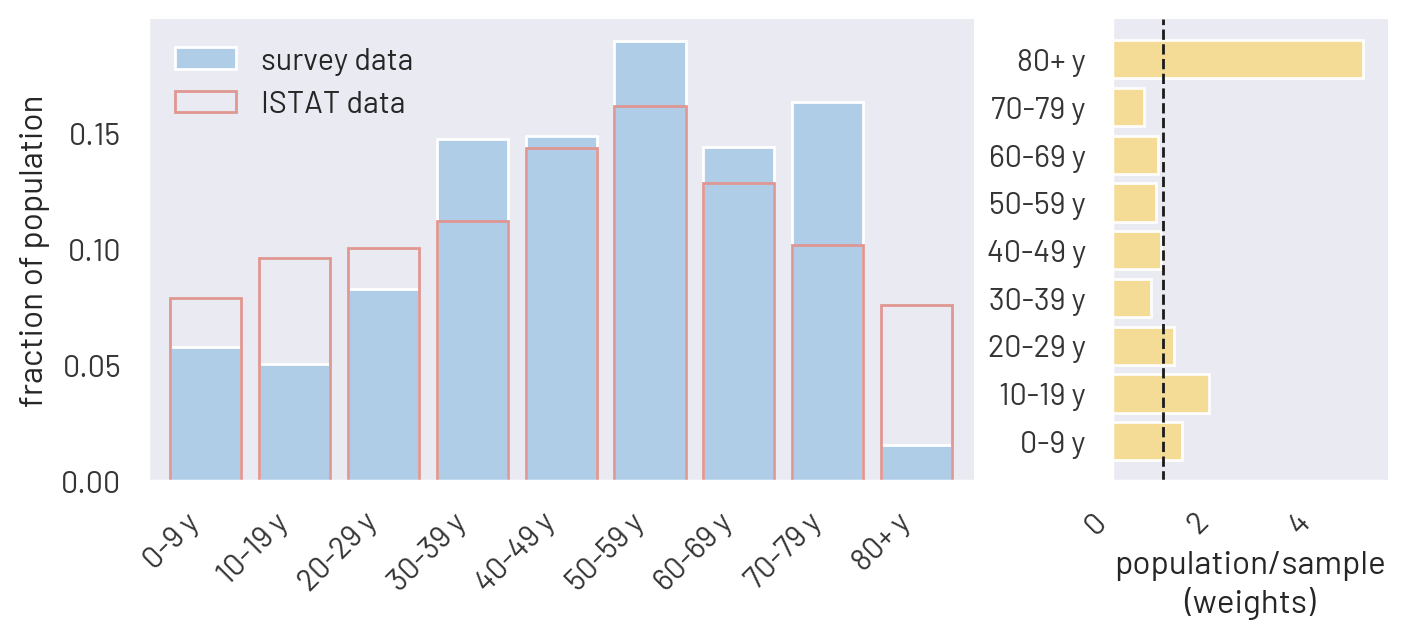

In [11]:
# Figure: 2 columns
fig, (ax1, ax2) = plt.subplots(
    ncols=2, figsize=(8, 3),
    gridspec_kw={"width_ratios": [3, 1], "wspace": 0.25}
)

# --- LEFT PANEL: fractions (same as yours) ---
toBar.loc[age_group_loc][['survey data']].plot(
    kind='bar', ax=ax1, color=[vale_palette[1]], width=0.8
)
ax1.bar(
    range(len(toBar.loc[age_group_loc])),
    height=toBar.loc[age_group_loc]['pop'],
    width=0.8, color='#00000000', edgecolor=vale_palette[5], label='ISTAT data'
)
set_plot_style(ax1)
ax1.set_ylabel('fraction of population')
ax1.set_xlabel('')
ax1.legend(frameon=False)

# --- RIGHT PANEL: relative weights (population ÷ sample) as HORIZONTAL bars ---
eps = 1e-12  # safety if any sample fraction is 0
weights = (
    toBar['pop'].div(toBar['survey data'] + eps)
).loc[age_group_loc]

ypos = np.arange(len(weights))
ax2.barh(ypos, list(weights)[::-1], height=0.8, color=vale_palette[3], alpha=0.95)

# reference line at 1 (perfect representativeness)
ax2.axvline(1, linestyle='--', linewidth=1, color='k')
# ax2.axvline(2, linestyle='--', linewidth=1, color='k')

# tidy axes
ax2.set_yticks(ypos)
ax2.set_yticklabels(list(age_group_loc)[::-1])
ax2.invert_yaxis()  # youngest on top → matches left-to-right order visually
set_plot_style(ax2)
ax2.set_xlabel('population/sample\n(weights)')
ax2.set_ylabel('')

# a sensible x-limit
xmax = float(np.nanmax(weights.values))
ax2.set_xlim(0, xmax * 1.1 if xmax > 1 else 1.5)

# Save
fig.savefig('figures_out/SIfigure2_representativeness_rebuttal.pdf',bbox_inches='tight')